# Post-run analysis

In the last tutorial, we simulated a Lennard-Jones crystal and stored data in the file `'LJ_T0.70.h5'`.
In this tutorial, we will analyse this data. Below, we will do some standard imports and load the data from the file on the disk.

In [8]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import h5py

import gamdpy as gp

# Select h5 file
filename='./LJ_T0.70.h5'
output = gp.tools.TrajectoryIO(filename).get_h5()

Found .h5 file (./LJ_T0.70.h5), loading to gamdpy as output dictionary


## Brief about the h5 data file

### Large data sets

Large data sets, such as the trajectory of particle positions, are stored as an HDF5 dataset (a data structure similar to a NumPy array, but data is stored on the disk).

In [9]:
nblocks, nconfs, N, D = output['trajectory_saver/positions'].shape
print(f'Number of timeblocks:          {nblocks = }')
print(f'Configurations per timeblock:  {nconfs = }')
print(f'Number of particles:           {N = }')
print(f'Number of spatial dimensions:  {D = }')

Number of timeblocks:          nblocks = 32
Configurations per timeblock:  nconfs = 12
Number of particles:           N = 2048
Number of spatial dimensions:  D = 3


### Information in attributes

Some information, such as details about the simulation box, is stored as attributes. Below, we fetch such data to get the density of the NVT simulation.

In [16]:
simbox = output['initial_configuration'].attrs['simbox_data']
volume = np.prod(simbox)
rho = N/volume
print(f'Density:  {rho = }')

Density:  rho = np.float32(0.97300005)


### Structure of h5 file
Below is a function to print the structure of a given h5 file.

In [13]:
def print_h5_structure(node, indent=0):
    """Recursively print groups & datasets with metadata."""
    for key, item in node.items():
        pad = "    " * indent
        if isinstance(item, h5py.Dataset):
            print(f"{pad}{key}  (Dataset, shape={item.shape}, dtype={item.dtype})")
        elif isinstance(item, h5py.Group):
            print(f"{pad}{key}/ (Group)")
            print_h5_structure(item, indent+1)
        else:  # This should not be relevant
            print(f"{pad}{key}  (Unknown type: {type(item)})")

print_h5_structure(output)

initial_configuration/ (Group)
    ptype  (Dataset, shape=(2048,), dtype=int32)
    r_im  (Dataset, shape=(2048, 3), dtype=int32)
    scalars  (Dataset, shape=(2048, 4), dtype=float32)
    topology/ (Group)
        angles  (Dataset, shape=(0,), dtype=int32)
        bonds  (Dataset, shape=(0,), dtype=int32)
        dihedrals  (Dataset, shape=(0,), dtype=int32)
        molecules/ (Group)
    vectors  (Dataset, shape=(3, 2048, 3), dtype=float32)
scalar_saver/ (Group)
    scalars  (Dataset, shape=(32, 64, 3), dtype=float32)
trajectory_saver/ (Group)
    images  (Dataset, shape=(32, 12, 2048, 3), dtype=int32)
    positions  (Dataset, shape=(32, 12, 2048, 3), dtype=float32)


### Attributes inside the H5 file
Below is a function that will print the attributes in a given h5 file.

In [17]:
def print_all_attrs(obj, path="/"):
    """Recursively print attrs of every group/dataset under obj."""
    # obj could be the File or a Group
    if obj.attrs:
        print(f"Attributes at {path}:")
        for name, val in obj.attrs.items():
            print(f"    • {name!r}: {val!r}")
    # Recurse into sub‐groups/datasets
    if isinstance(obj, h5py.Group):
        for key, sub in obj.items():
            print_all_attrs(sub, path + key + ("/" if isinstance(sub, h5py.Group) else ""))

# Run it on your file
print_all_attrs(output)

Attributes at /:
    • 'dt': np.float64(0.005)
    • 'script_content': '"""Entry point for launching an IPython kernel.\n\nThis is separate from the ipykernel package so we can avoid doing imports until\nafter removing the cwd from sys.path.\n"""\n\nimport sys\nfrom pathlib import Path\n\nif __name__ == "__main__":\n    # Remove the CWD from sys.path while we load stuff.\n    # This is added back by InteractiveShellApp.init_path()\n    if sys.path[0] == "" or Path(sys.path[0]) == Path.cwd():\n        del sys.path[0]\n\n    from ipykernel import kernelapp as app\n\n    app.launch_new_instance()\n'
    • 'script_name': '/home/urp/PycharmProjects/gamdpy/.venv3/lib/python3.13/site-packages/ipykernel_launcher.py'
Attributes at /initial_configuration/:
    • 'simbox_data': array([12.815602, 12.815602, 12.815602], dtype=float32)
    • 'simbox_name': 'Orthorhombic'
Attributes at /initial_configuration/scalars:
    • 'scalar_columns': array(['U', 'W', 'K', 'm'], dtype=object)
Attributes at /ini

## Thermodynamics

The gamdpy package contains helper functions to read data in .h5 files.
Thermodynamic data, stored in the `'scalar_saver'` group, can be extracted using the `gp.extract_scalars()` function (we skip the first block with `first_block=1` since the system is not equilibrated).

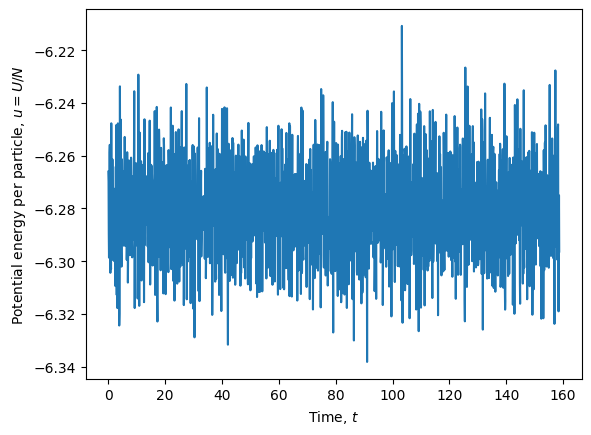

In [11]:
# Extract thermodynamic data
U, W, K = gp.extract_scalars(output, ['U', 'W', 'K'], first_block=1)

# Get times
dt = output.attrs['dt']  # Timestep
time = np.arange(len(U)) * dt * output['scalar_saver'].attrs['steps_between_output']

# Plot potential energy per particle as a function of time
plt.figure()
plt.plot(time, U/N)
plt.xlabel(r'Time, $t$')
plt.ylabel('Potential energy per particle, $u=U/N$')
plt.show()

Some properties need to be computed from the data stored. Examples are the kinetic temperature and pressure (in LJ units).

In [50]:
# Compute instantaneous kinetic temperature
dof = D * N - D  # degrees of freedom
T_kin = 2 * K / dof

# Compute instantaneous pressure
P = rho * T_kin + W / volume

print(f'Mean kinetic temperature:  {np.mean(T_kin) = }')
print(f'Mean pressure:             {np.mean(P) = }')

Mean kinetic temperature:  np.mean(T_kin) = np.float32(0.69985)
Mean pressure:             np.mean(P) = np.float32(1.4038391)


## Structure

To investigate the structure and dynamics of particles, we need to analyse data in the `'trajectory_saver'` group. Again, gamdpy has some built-in functionality to compute various measures. Let us calculate the radial distribution function. We will do this by inserting positions into a configuration object, and using the `gamdpy.CalculatorRadialDistribution()` class. The calculation is done on the GPU (for efficency).

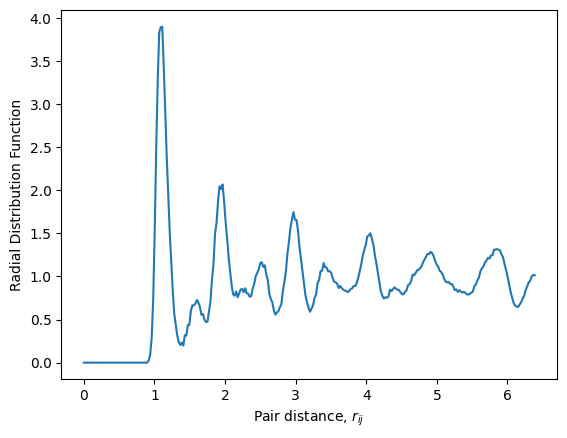

In [46]:
# Create configuration object
configuration = gp.Configuration(D=D, N=N)
configuration.simbox = gp.Orthorhombic(D, output['initial_configuration'].attrs['simbox_data'])
configuration.ptype = output['initial_configuration/ptype']
configuration.copy_to_device()

# Call the radial distribution (RDF) calculator
calc_rdf = gp.CalculatorRadialDistribution(configuration, bins=300)

# Loop positions and compute the RDF
positions = output['trajectory_saver/positions'][:,:,:,:]
positions = positions.reshape(nblocks*nconfs,N,D)

# Loop over the last configurations in each time block
skipped_timeblocks = 1
start = nconfs-1+skipped_timeblocks*nconfs
step = nconfs
for pos in positions[start::step]:
    configuration['r'] = pos
    configuration.copy_to_device()
    calc_rdf.update()
rdf_data = calc_rdf.read()

# Plot RDF
plt.figure()
plt.plot(rdf_data['distances'], rdf_data['rdf'][0])
plt.xlabel(r'Pair distance, $r_{ij}$')
plt.ylabel('Radial Distribution Function')
plt.savefig(filename+'_rdf.pdf')
plt.show()

## Dynamics

There are also built-in tools for analysing the trajectory. For example, the `gamdpy.tools.calc_dynamics` function computes several dynamical measures, including the mean squared displacement and the intermediate scattering function.

In [69]:
qvalues = 7.5
dynamics = gp.tools.calc_dynamics(output, first_block=1, qvalues=qvalues)  # Dictionary with dynamics
dynamics.keys()

dict_keys(['times', 'msd', 'alpha2', 'qvalues', 'Fs', 'count'])

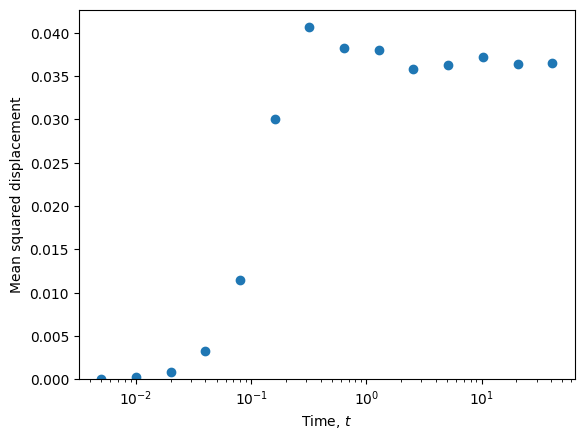

In [70]:
plt.figure()
plt.plot(dynamics['times'], dynamics['msd'], 'o')
plt.xscale('log')
plt.ylim(0, None)
plt.xlabel(r'Time, $t$')
plt.ylabel(r'Mean squared displacement')
plt.show()

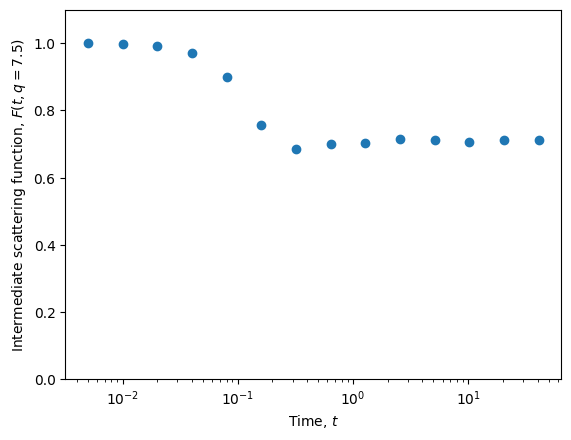

In [73]:
plt.figure()
plt.plot(dynamics['times'], dynamics['Fs'], 'o')
plt.xscale('log')
plt.ylim(0, 1.1)
plt.xlabel(r'Time, $t$')
plt.ylabel(r'Intermediate scattering function, $F(t, q = ' f'{qvalues}' r'$)')
plt.show()

## Concluding remarks

You have now conducted your first simulation and done some post-analysis of the trajectory. You now understand the basics of how gamdpy works, and are ready for more advanced simulations and analysis - see examples.